# Recommender System - EDA

Explore dataset's:
- Sparsity
- Distribution
- Temporal Patterns
- New users / items --> cold start

## Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.ml.recommendation import ALS

ModuleNotFoundError: No module named 'pyspark'

## Data Loading

In [23]:
movies = pd.read_csv("../data/raw/movie.csv")
links = pd.read_csv("../data/raw/link.csv")
ratings = pd.read_csv("../data/raw/rating.csv", parse_dates=['timestamp'],
                     dtype={'userId':'int32','movieId':'int32'})
tags = pd.read_csv("../data/raw/tag.csv")
genome_scores = pd.read_csv("../data/raw/genome_scores.csv")
genome_tags = pd.read_csv("../data/raw/genome_tags.csv")

In [24]:
ratings.info(memory_usage='deep') 
# 610.4Mb -- > 457.8Mb via userId & movieId going from int64 to int32

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int32         
 1   movieId    int32         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 457.8 MB


In [9]:
ratings.isnull().value_counts() # no nulls

userId  movieId  rating  timestamp
False   False    False   False        20000263
dtype: int64

In [16]:
ratings.describe().round(2)
# rating values in correct range
# userId and movie Id can be int32 due to size

,userId,movieId,rating
count,20000263.00,20000263.00,20000263.00
mean,69045.87,9041.57,3.53
std,40038.63,19789.48,1.05
min,1.00,1.00,0.50
25%,34395.00,902.00,3.00
50%,69141.00,2167.00,3.50
75%,103637.00,4770.00,4.00
max,138493.00,131262.00,5.00


In [17]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [49]:
df = ratings

## Sparsity
For a user-item matrix, how sparse is the data, i.e. how many blank datapoints are there for each user.\
Results: 0.54% is reasonable for such a large dataset. Matrix Factorisation (MF) techniques, e.g. ALS will be ideal.

In [50]:
total_users = df.userId.nunique()
total_films = df.movieId.nunique()
total_ratings = df.shape[0]

In [100]:
sparsity = total_ratings/(total_users*total_films)*100
print(f'Total Sparsity: {sparsity:.2f} %')

Total Sparsity: 0.54 %


## Distribution of Ratings per Movie
A heavily skewed dataset that has many films with few ratings can cause potential issues even with MF. A histogram is used to display the distribution.

In [69]:
ratings_per_movie = (
    df.groupby('movieId')
    .agg(total_reviews=('rating','count'))
    .sort_values('total_reviews')
)

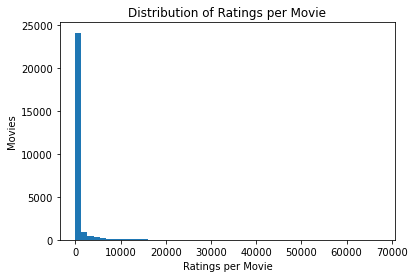

In [72]:
# Plotting hist
plt.hist(ratings_per_movie, bins=50)
plt.xlabel("Ratings per Movie")
plt.ylabel("Movies")
plt.title("Distribution of Ratings per Movie")
plt.show()

In [73]:
ratings_per_movie.describe()

,total_reviews
count,26744.000000
mean,747.841123
std,3085.818268
min,1.000000
25%,3.000000
50%,18.000000
75%,205.000000
max,67310.000000


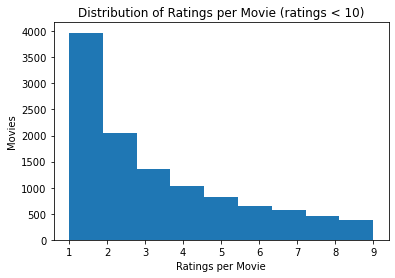

In [94]:
# Showcasing films in the smallest bucket, i.e. < 10 reviews
plt.hist(ratings_per_movie[ratings_per_movie.total_reviews < 10], bins=9)
plt.xlabel("Ratings per Movie")
plt.ylabel("Movies")
plt.title("Distribution of Ratings per Movie (ratings < 10)")
plt.show()

In [103]:
pct_lt_5 = (ratings_per_movie.total_reviews<5).mean()
pct_lt_10 = (ratings_per_movie.total_reviews<10).mean()
print(f'{100*pct_lt_5:.1f} % of films have less than 5 reviews')
print(f'{100*pct_lt_10:.1f} % of films have less than 10 reviews')

31.4 % of films have less than 5 reviews
42.2 % of films have less than 10 reviews
